In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import datetime
%matplotlib inline

In [2]:
all_files = glob.glob('../Processed_dataframes/*pkl')
all_files.sort()
print len(all_files)

31


In [3]:
# Load in all dataframes and store in dictionary by date
all_dfs = {}
for f in all_files:
    run_date = re.findall('\d{8}', f)[0]
    run_date = datetime.date(int(run_date[:4]), int(run_date[4:6]), int(run_date[6:]))
    df_tmp = pd.read_pickle(f)
    if df_tmp.activity_time.max() > 1000:
        continue
    all_dfs[run_date] = df_tmp      # Add to dictionary, with date as key

In [4]:
# Convert dict to dataframe with multi-index (0-level=date, 1-level=)
all_dfs = pd.concat(all_dfs)
all_dfs.index = pd.MultiIndex.from_tuples([(x[0], x[1]) for x in all_dfs.index])
all_dfs.index.levels[0]

DatetimeIndex(['2019-01-09', '2019-01-17', '2019-01-23', '2019-01-24',
               '2019-01-28', '2019-01-30', '2019-01-31', '2019-02-06',
               '2019-02-07', '2019-02-11', '2019-02-13', '2019-02-14',
               '2019-02-18', '2019-02-20', '2019-02-21', '2019-02-25',
               '2019-02-28', '2019-03-04', '2019-03-07', '2019-03-11',
               '2019-03-14', '2019-03-18', '2019-03-20', '2019-03-21',
               '2019-03-25', '2019-03-27', '2019-03-28'],
              dtype='datetime64[ns]', freq=None)

In [5]:
print all_dfs.columns

Index([u'cadence', u'distance', u'speed', u'watts', u'activity_time',
       u'calories', u'heart_rate'],
      dtype='object')


# Full resolution

In [6]:
date_colour = plt.cm.viridis((all_dfs.index.levels[0] - all_dfs.index.levels[0][0]).days.astype('float') /
                             (all_dfs.index.levels[0][-1] - all_dfs.index.levels[0][0]).days)

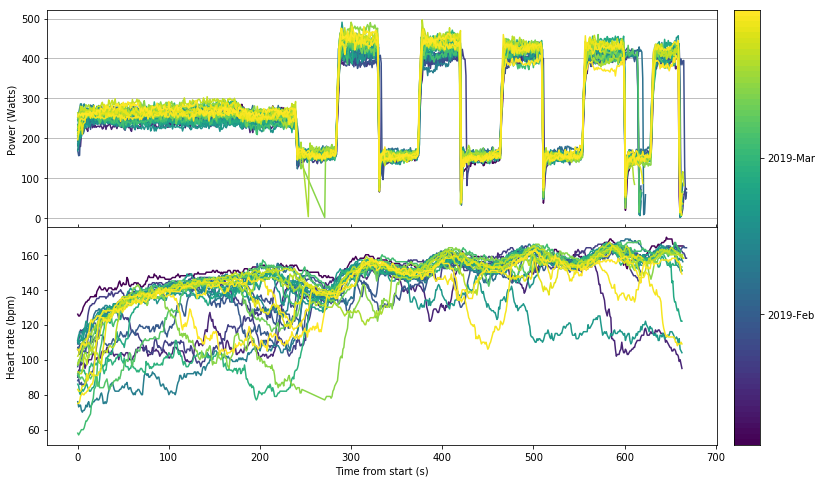

In [23]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(211, ylabel='Power (Watts)', xticklabels=[])
for i, ind in enumerate(all_dfs.index.levels[0]):
    ax.plot(all_dfs.loc[ind].activity_time, all_dfs.loc[ind].watts, c=date_colour[i])
ax.tick_params('x', direction='in')
plt.grid(axis='y')

ax1 = f.add_subplot(212, ylabel='Heart rate (bpm)', xlabel='Time from start (s)')
for i, ind in enumerate(all_dfs.index.levels[0]):
    ax1.plot(all_dfs.loc[ind].activity_time, all_dfs.loc[ind].heart_rate, c=date_colour[i])

f.subplots_adjust(hspace=0, right=0.9)
map_range = np.arange((all_dfs.index.levels[0][-1] - all_dfs.index.levels[0][0]).days)
map_2d = np.array([map_range, map_range]).T
ax2 = f.add_axes([0.92, 0.125, 0.03, 0.755], xticks=[])
tick_dates = np.array([datetime.datetime(2019, 2, 1), datetime.datetime(2019, 3, 1)]) - all_dfs.index.levels[0][0]
ax2.set_yticks([tdate.days for tdate in tick_dates])
ax2.set_yticklabels(['2019-Feb', '2019-Mar'])
ax2.yaxis.tick_right()
ax2.imshow(map_2d, cmap=plt.cm.viridis, aspect='auto', interpolation='none', origin='lower')
plt.show()

## Mask bad heart rate values

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


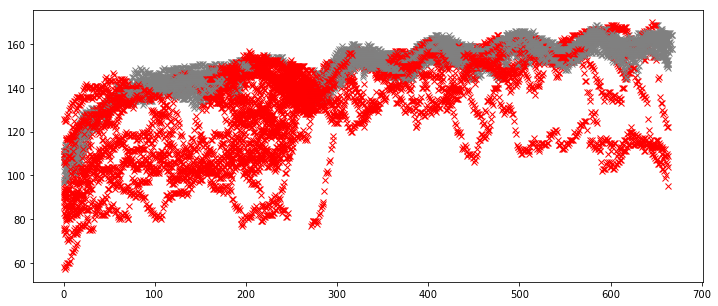

In [8]:
# Subtract median HR from each time step (over all sessions)
residuals = all_dfs[['activity_time', 'heart_rate']].copy()
for i in np.unique(residuals.activity_time):
    mask = ~np.isnan(residuals.heart_rate[residuals.activity_time==i])
    med_tmp = np.nanmedian(residuals.heart_rate[residuals.activity_time==i][mask])
    residuals.heart_rate[residuals.activity_time==i] -= med_tmp

# Mask extreme small HR values
all_dfs['HR_valid'] = np.ones(all_dfs.shape[0], dtype=bool)
all_dfs.HR_valid[residuals.heart_rate < -20] = 0
# Mask values with large residual standard deviation
for ind in all_dfs.index.levels[0]:
    #print ind
    for i in range(all_dfs.loc[ind].shape[0]):
        window_low = i - 50 if (i-50) > 0 else 0
        window_hi = i + 50 if (i+50) < all_dfs.loc[ind].shape[0] else all_dfs.loc[ind].shape[0]
        if np.nanstd(residuals.heart_rate.loc[ind].iloc[window_low:window_hi]) > 4:
            all_dfs.HR_valid.loc[ind].iloc[i] = 0
            
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(111)
for ind in all_dfs.index.levels[0]:
    df_tmp = all_dfs.loc[ind]
    #df_tmp2 = residuals.loc[ind]
    ax.plot(df_tmp.activity_time[df_tmp.HR_valid], df_tmp.heart_rate[df_tmp.HR_valid], 'x', c='0.5')
    ax.plot(df_tmp.activity_time[~df_tmp.HR_valid], df_tmp.heart_rate[~df_tmp.HR_valid], 'x', c='r')
plt.show()

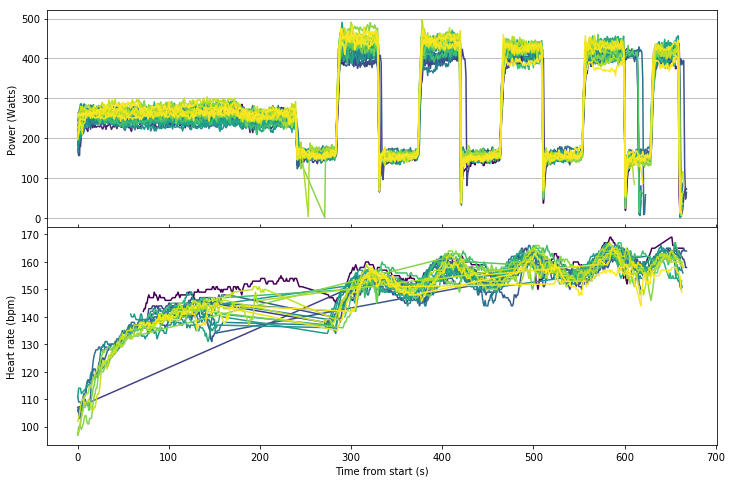

In [9]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(211, ylabel='Power (Watts)', xticklabels=[])
for i, ind in enumerate(all_dfs.index.levels[0]):
    ax.plot(all_dfs.loc[ind].activity_time, all_dfs.loc[ind].watts, c=date_colour[i])
ax.tick_params('x', direction='in')
plt.grid(axis='y')

ax1 = f.add_subplot(212, ylabel='Heart rate (bpm)', xlabel='Time from start (s)')
for i, ind in enumerate(all_dfs.index.levels[0]):
    mask = all_dfs.loc[ind].HR_valid
    ax1.plot(all_dfs.loc[ind].activity_time[mask], all_dfs.loc[ind].heart_rate[mask], c=date_colour[i])
f.subplots_adjust(hspace=0)
plt.show()

# Average sprint

In [10]:
df_mean_sprint = all_dfs[(all_dfs.watts > 325) & (all_dfs.activity_time < 601)].groupby(level=0).mean()
df_mean_sprint.index.name = 'date'
df_mean_sprint.head()

,cadence,distance,speed,watts,activity_time,calories,heart_rate,HR_valid
date,,,,,,,,
2019-01-09,109.973684,4927.972807,13.391813,409.222222,442.228070,112.356725,159.023392,1.000000
2019-01-17,109.728324,4854.314971,13.279653,400.005780,443.080925,79.595376,141.052023,0.000000
2019-01-23,108.646067,4907.339157,13.237022,396.421348,443.398876,102.738764,156.011236,0.252809
2019-01-24,108.071823,5015.312044,13.359613,406.629834,442.977901,83.491713,156.480663,0.917127
2019-01-28,109.483240,4928.974134,13.267263,398.983240,439.888268,97.659218,155.793296,1.000000


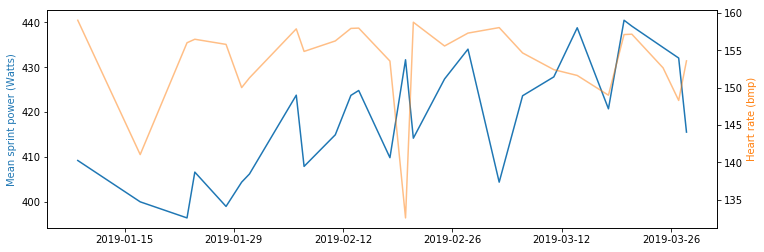

In [11]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(111)
ax.set_ylabel('Mean sprint power (Watts)', color='C0')
ax.plot(df_mean_sprint.index, df_mean_sprint.watts)
ax1 = ax.twinx()
ax1.set_ylabel('Heart rate (bmp)', color='C1')
ax1.plot(df_mean_sprint.index, df_mean_sprint.heart_rate, 'C1', alpha=0.5)
plt.show()

## Sprint consistency

Look at the percentage difference between the average power in the first 2 sprints vs the 3rd and 4th sprint, i.e. $$\frac{P_{\text{last}} - P_{\text{first}}}{P_{\text{first}}} \times 100$$

In [12]:
first = all_dfs[(all_dfs.watts > 325) & (all_dfs.activity_time < 440)].groupby(level=0).mean()
last = all_dfs[(all_dfs.watts > 325) & (all_dfs.activity_time > 440) & (all_dfs.activity_time < 601)].groupby(level=0).mean()
sprint_diff = 100 * (last - first) / first

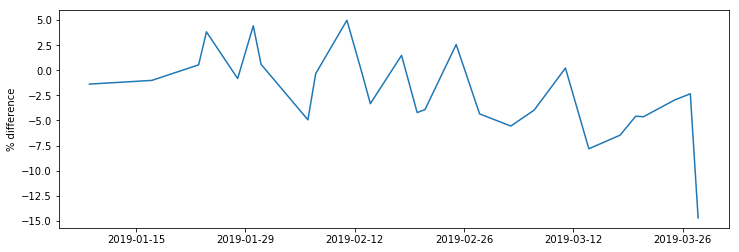

In [13]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(111, ylabel='% difference')
ax.plot(sprint_diff.index, sprint_diff.watts)
plt.show()

So, although plot above shows that the average sprint power has been increasing over time, this one shows that the power is dropping off more in the latter sprints relative to the first, i.e. probably pushing too hard on the first 2 sprints and burning out

## Day of the week comparison

In [14]:
# df.dayofweek gives Monday = 0 -- Sunday = 6
df_mean_sprint['weekday'] = df_mean_sprint.index.dayofweek

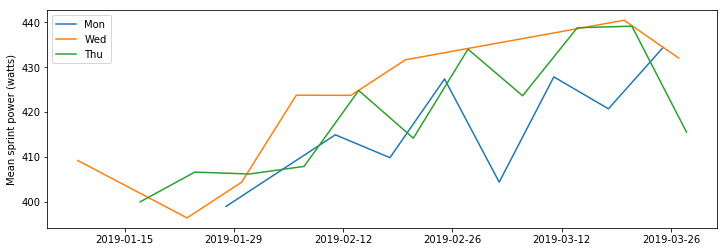

In [15]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(111, ylabel='Mean sprint power (watts)')
ax.plot(df_mean_sprint[df_mean_sprint.weekday == 0].index, df_mean_sprint[df_mean_sprint.weekday == 0].watts, label='Mon')
ax.plot(df_mean_sprint[df_mean_sprint.weekday == 2].index, df_mean_sprint[df_mean_sprint.weekday == 2].watts, label='Wed')
ax.plot(df_mean_sprint[df_mean_sprint.weekday == 3].index, df_mean_sprint[df_mean_sprint.weekday == 3].watts, label='Thu')
ax.legend()
plt.show()

In [16]:
# df.dayofweek gives Monday = 0 -- Sunday = 6
sprint_diff['weekday'] = sprint_diff.index.dayofweek

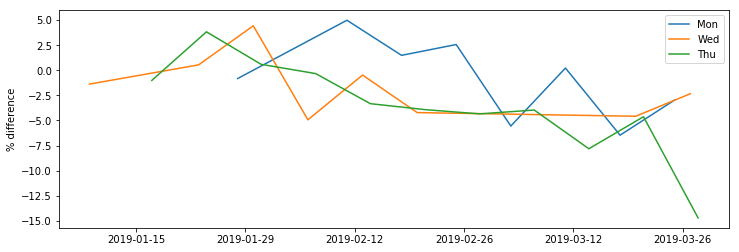

In [17]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(111, ylabel='% difference')
ax.plot(sprint_diff[sprint_diff.weekday == 0].index, sprint_diff[sprint_diff.weekday == 0].watts, label='Mon')
ax.plot(sprint_diff[sprint_diff.weekday == 2].index, sprint_diff[sprint_diff.weekday == 2].watts, label='Wed')
ax.plot(sprint_diff[sprint_diff.weekday == 3].index, sprint_diff[sprint_diff.weekday == 3].watts, label='Thu')
ax.legend()
plt.show()